In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=eee88f79c4bda6572cff3d6b97cb14fe3644c89a64e96b850c7b1559154b4ab6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, col, count
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.ticker as ticker

# Iniciar una sesión de Spark
spark = SparkSession.builder.appName("AirTrafficAnalysis").getOrCreate()

# Cargar el conjunto de datos
data_path = '/content/drive/MyDrive/Proyecto Final/Proyecto BigData/'

data = spark.read.options(inferSchema='True',delimiter=',', header=True).csv(data_path + 'Air_Traffic_Passenger_Statistics.csv')
data.take(2)

# Mostrar el esquema del dataframe
data.printSchema()

# Mostrar los primeros registros del dataframe
data.show(5)

root
 |-- Activity Period: integer (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+-------

In [ ]:
# Modificar los tipos de datos de las columnas si es necesario
df = data.withColumn("Activity Period", col("Activity Period").cast("integer"))
df = data.withColumn("Year", col("Year").cast("integer"))
df = data.withColumn("Passenger Count", col("Passenger Count").cast("integer"))
df = data.withColumn("Adjusted Passenger Count", col("Adjusted Passenger Count").cast("integer"))

<ipython-input-6-a04aa0fcdc64>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


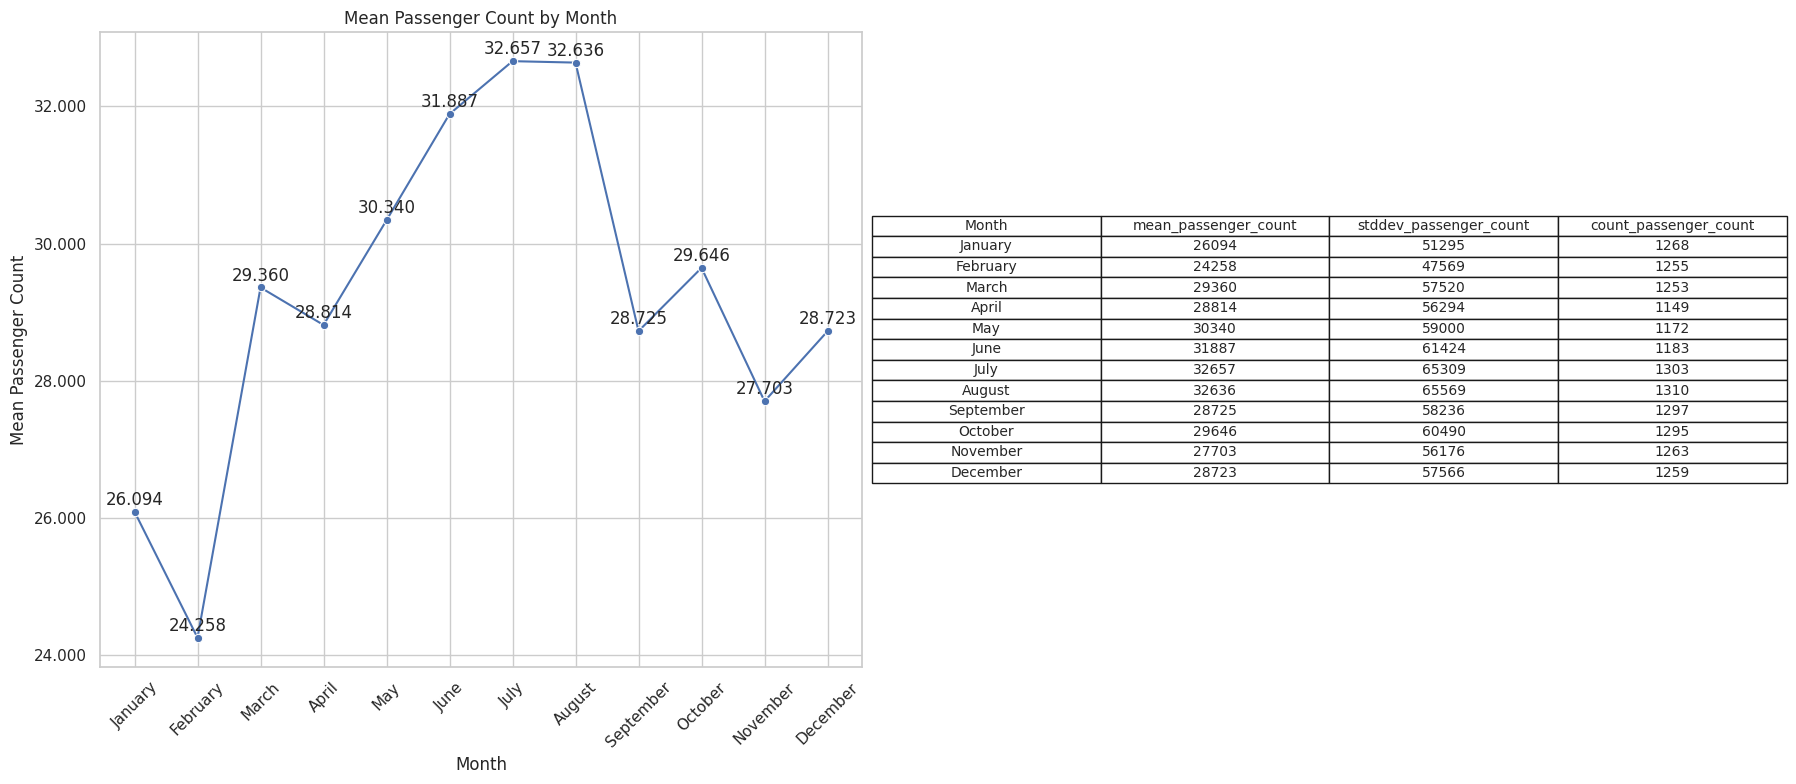

<ipython-input-6-a04aa0fcdc64>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


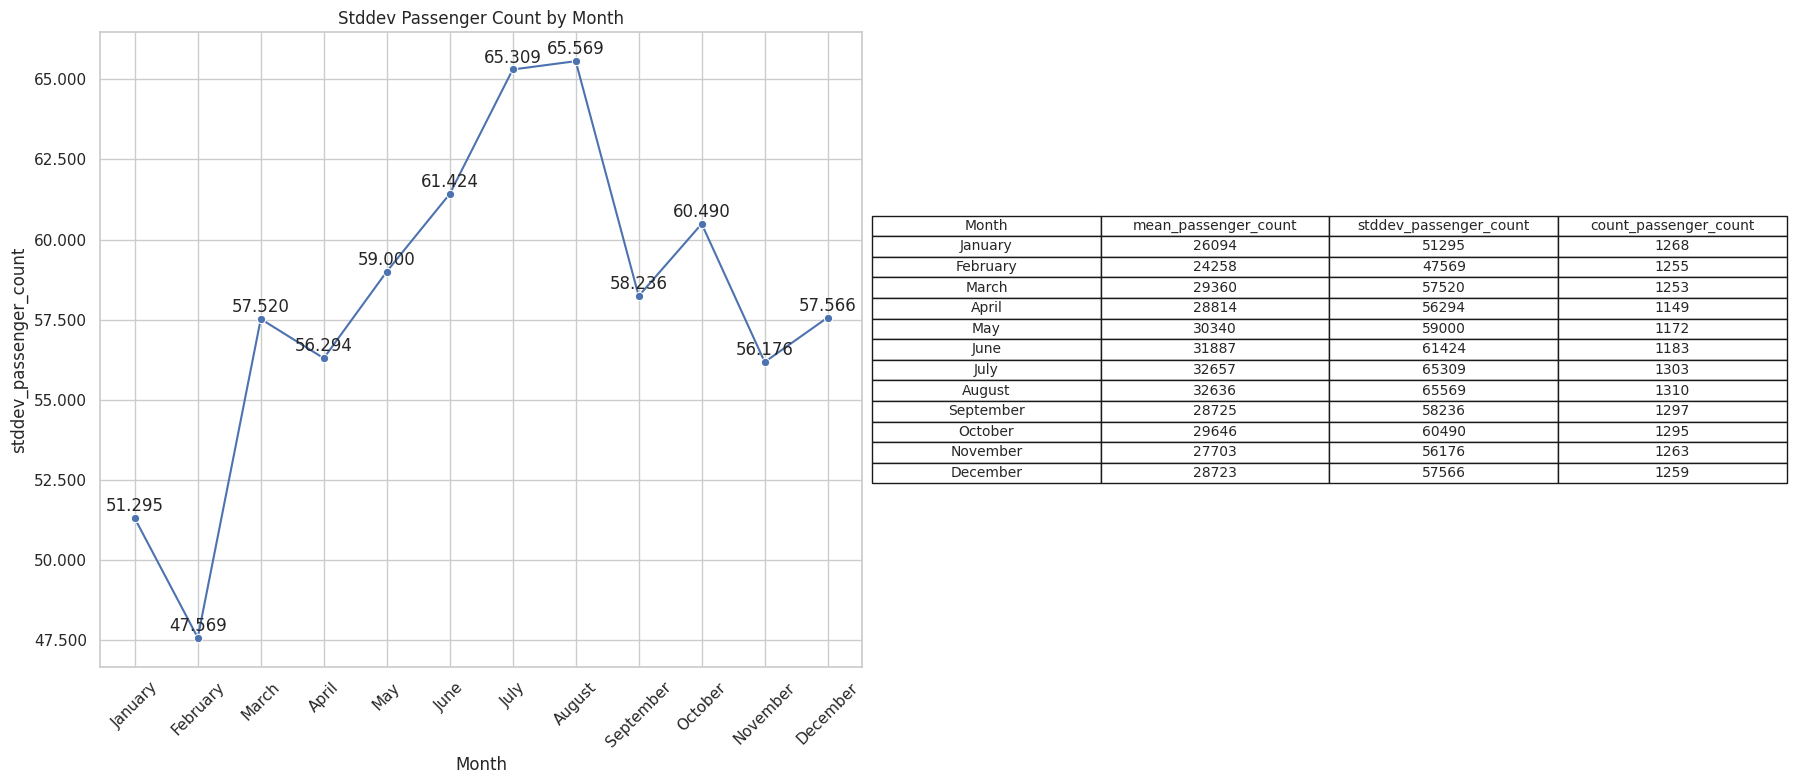

In [ ]:
# Relacionar Passenger Count con Month y calcular estadísticas
passenger_month_stats = df.groupBy("Month").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas
passenger_month_stats['mean_passenger_count'] = passenger_month_stats['mean_passenger_count'].round(0).astype(int)
passenger_month_stats['stddev_passenger_count'] = passenger_month_stats['stddev_passenger_count'].round(0).astype(int)
passenger_month_stats['count_passenger_count'] = passenger_month_stats['count_passenger_count'].round(0).astype(int)

# Convertir la columna 'Month' a categórico con el orden específico
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
passenger_month_stats['Month'] = pd.Categorical(passenger_month_stats['Month'], categories=month_order, ordered=True)

# Ordenar el DataFrame por 'Month'
passenger_month_stats = passenger_month_stats.sort_values('Month')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas para Passenger Count con Month (Mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.lineplot(data=passenger_month_stats, x='Month', y='mean_passenger_count', marker='o', ax=ax1)
ax1.set_title('Mean Passenger Count by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_month_stats.iterrows():
    ax1.annotate(f"{row['mean_passenger_count']:,.0f}".replace(',', '.'), (row['Month'], row['mean_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_month_stats.values, colLabels=passenger_month_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Crear el gráfico de líneas para Passenger Count con Month (Stddev)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.lineplot(data=passenger_month_stats, x='Month', y='stddev_passenger_count', marker='o', ax=ax1)
ax1.set_title('Stddev Passenger Count by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('stddev_passenger_count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_month_stats.iterrows():
    ax1.annotate(f"{row['stddev_passenger_count']:,.0f}".replace(',', '.'), (row['Month'], row['stddev_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_month_stats.values, colLabels=passenger_month_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

<ipython-input-9-873cbff61c94>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


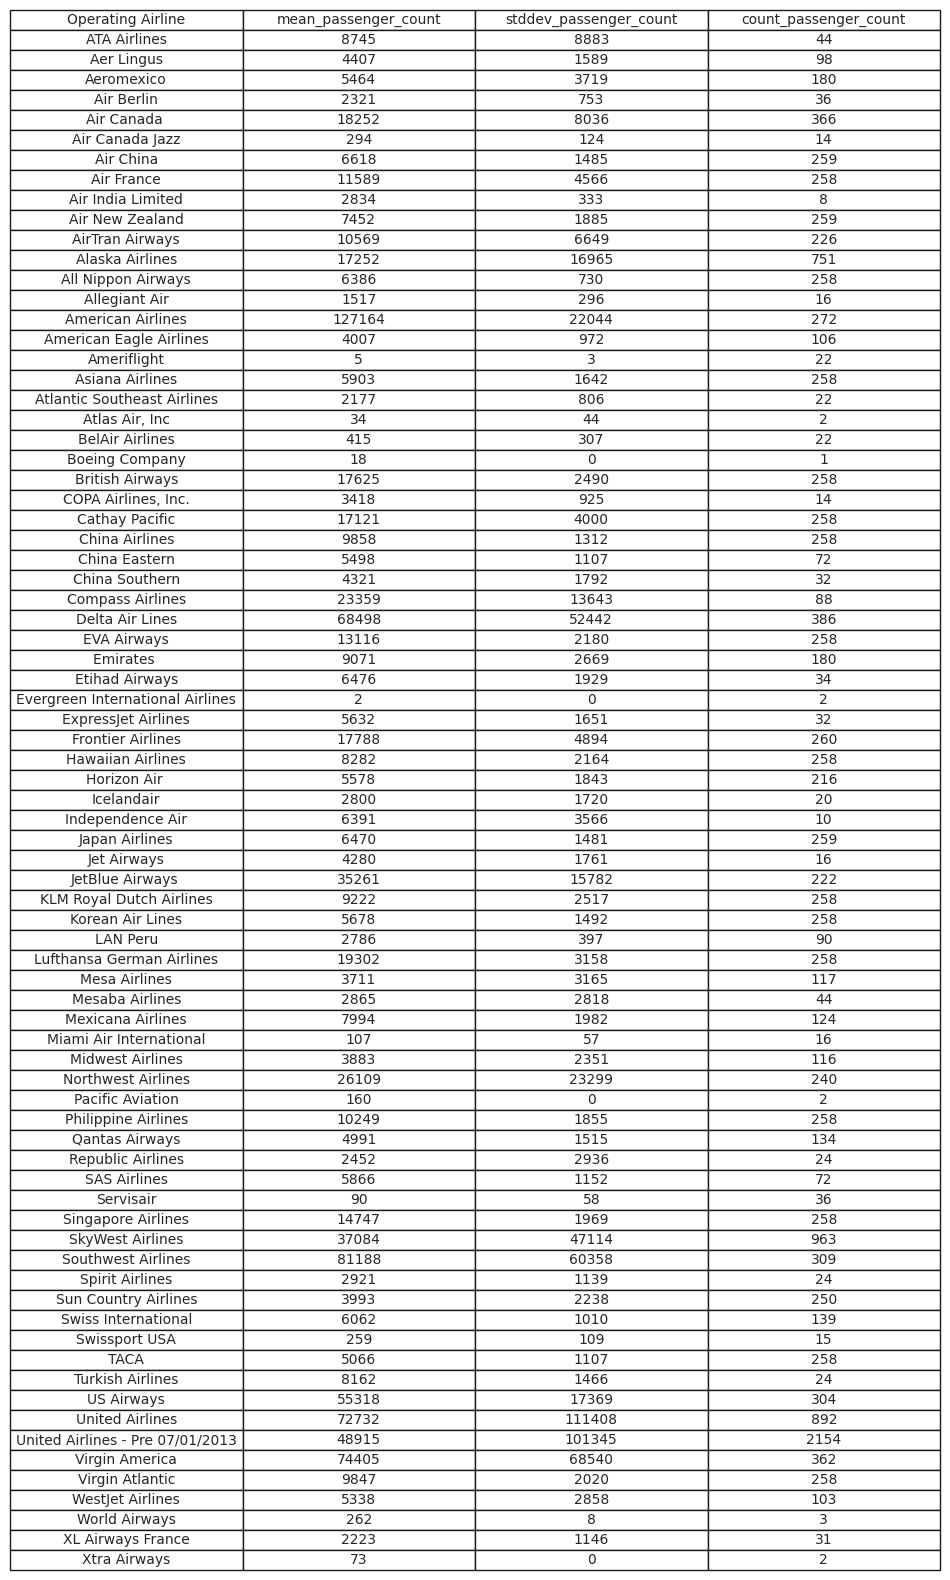

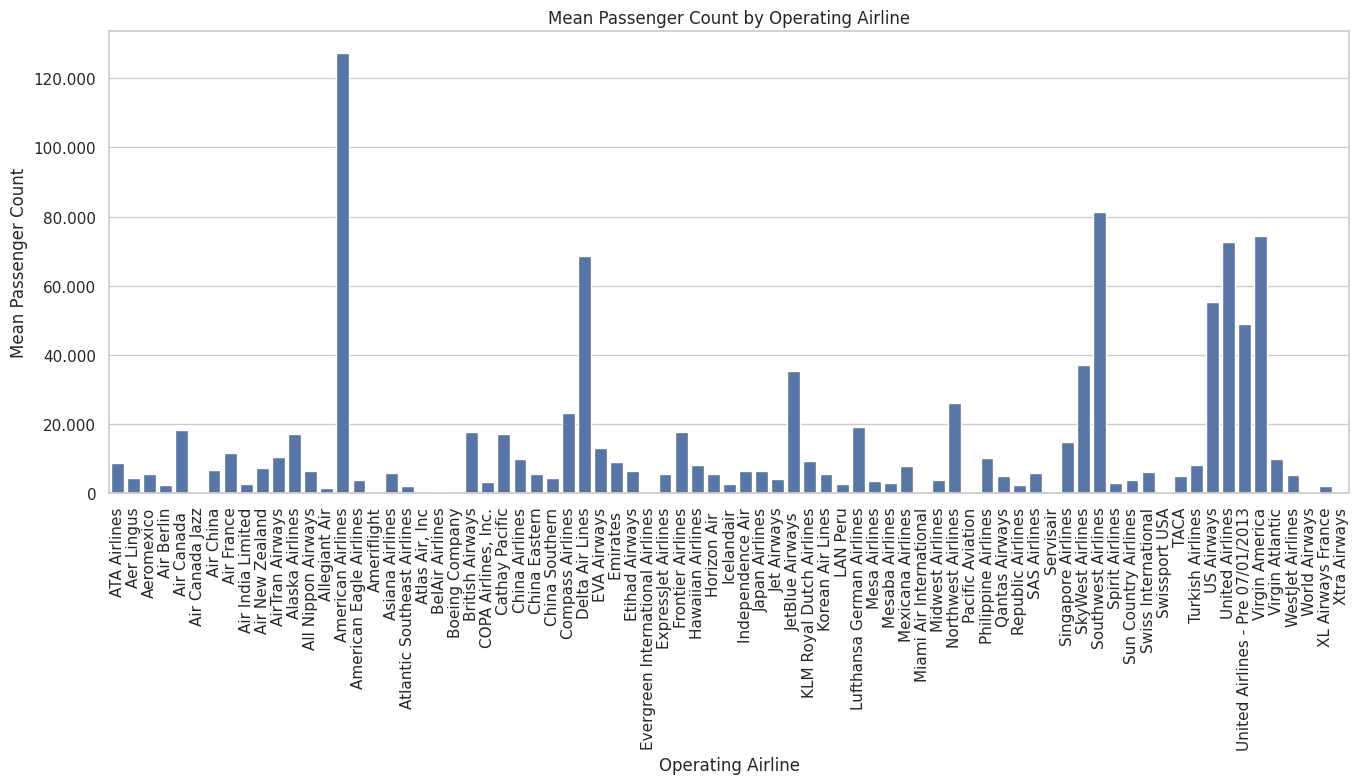

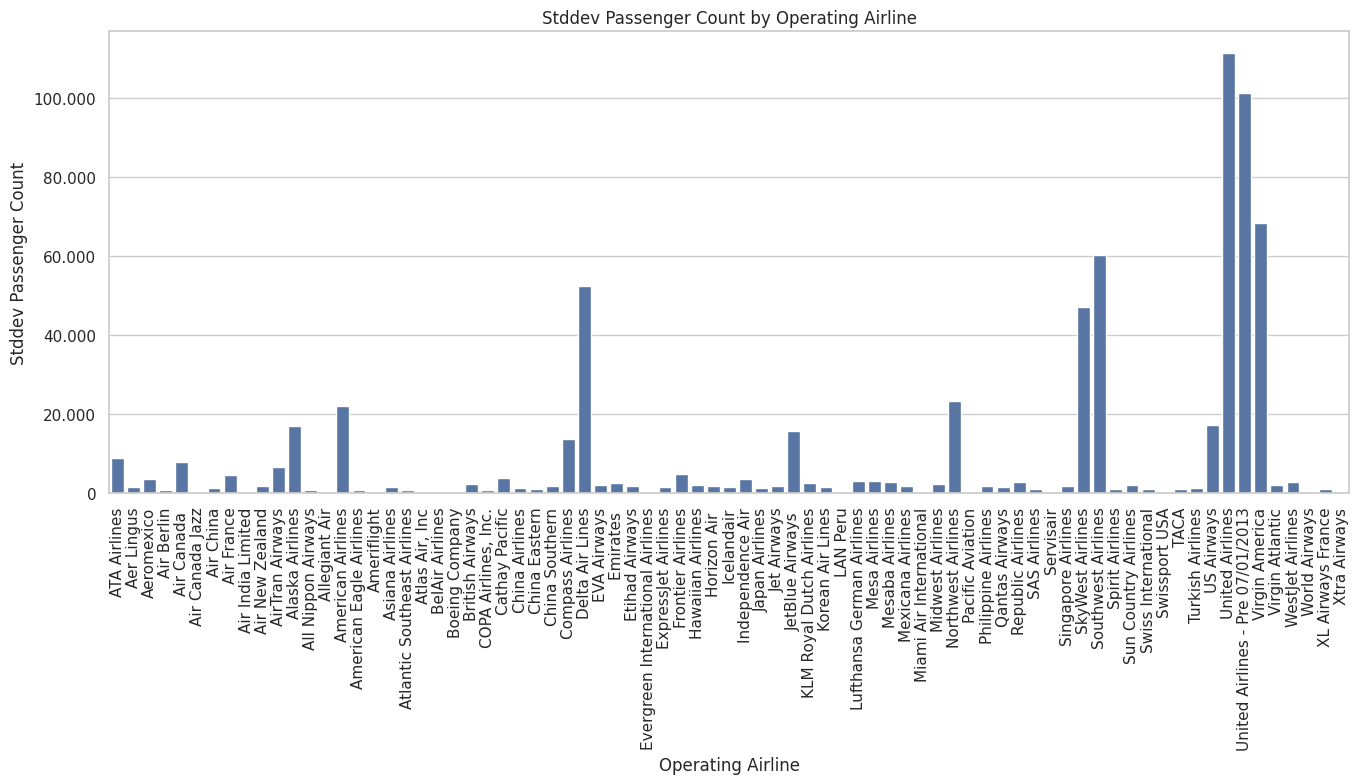

In [ ]:
# Relacionar Passenger Count con Operating Airline
passenger_airline_stats = df.groupBy("Operating Airline").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas sin decimales
passenger_airline_stats['mean_passenger_count'] = passenger_airline_stats['mean_passenger_count'].round(0).astype(int)
passenger_airline_stats['stddev_passenger_count'] = passenger_airline_stats['stddev_passenger_count'].fillna(0).round(0).astype(int)
passenger_airline_stats['count_passenger_count'] = passenger_airline_stats['count_passenger_count'].round(0).astype(int)

# Ordenar las estadísticas alfabéticamente por Operating Airline
passenger_airline_stats = passenger_airline_stats.sort_values('Operating Airline')

# Crear una figura para la tabla
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=passenger_airline_stats.values, colLabels=passenger_airline_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de Barras para Passenger Count con Operating Airline (mean)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=passenger_airline_stats, x='Operating Airline', y='mean_passenger_count')
plt.title('Mean Passenger Count by Operating Airline')
plt.xlabel('Operating Airline')
plt.ylabel('Mean Passenger Count')
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
plt.show()

# Gráfico de Barras para Passenger Count con Operating Airline (stddev)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=passenger_airline_stats, x='Operating Airline', y='stddev_passenger_count')
plt.title('Stddev Passenger Count by Operating Airline')
plt.xlabel('Operating Airline')
plt.ylabel('Stddev Passenger Count')
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
plt.show()

<ipython-input-11-e0e53ad213c6>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


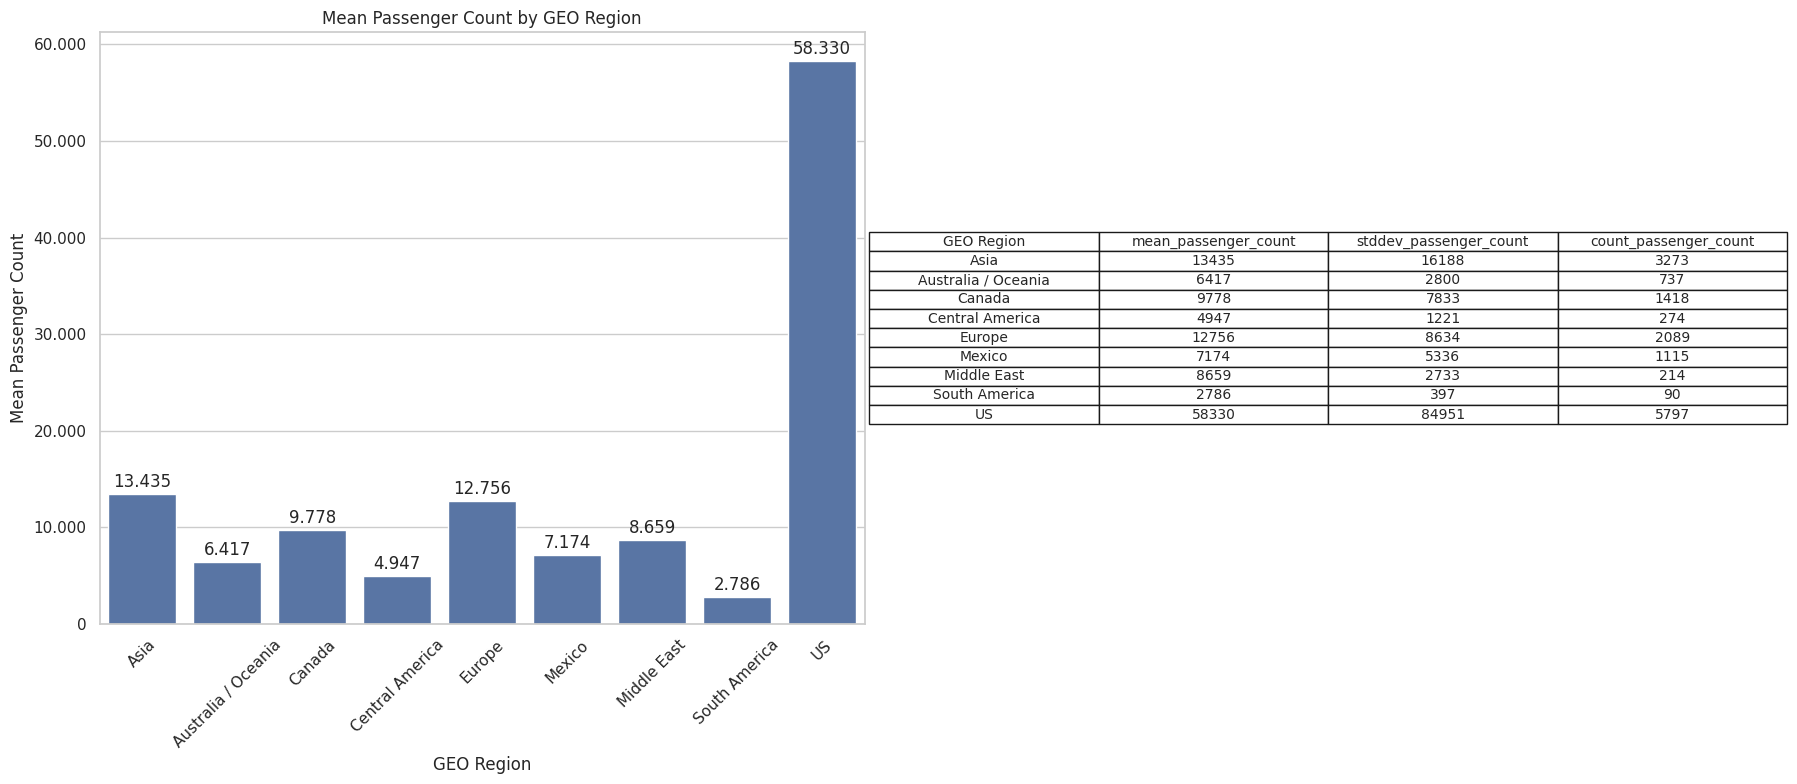

<ipython-input-11-e0e53ad213c6>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


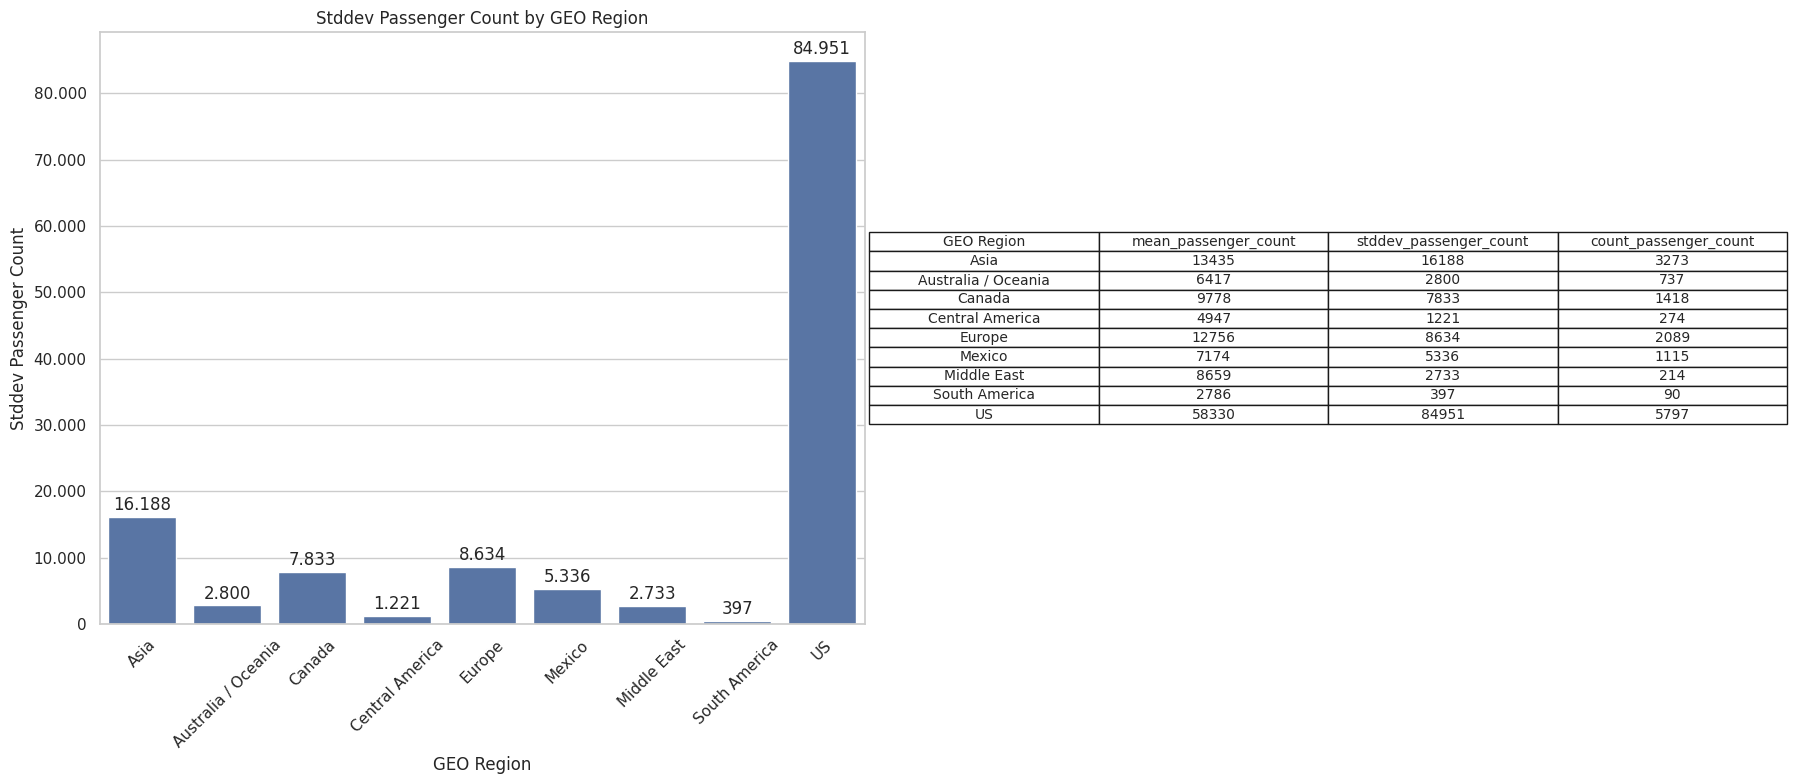

In [ ]:
# Relacionar Passenger Count con GEO Region
passenger_geo_region_stats = df.groupBy("GEO Region").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas sin decimales
passenger_geo_region_stats['mean_passenger_count'] = passenger_geo_region_stats['mean_passenger_count'].round(0).astype(int)
passenger_geo_region_stats['stddev_passenger_count'] = passenger_geo_region_stats['stddev_passenger_count'].fillna(0).round(0).astype(int)
passenger_geo_region_stats['count_passenger_count'] = passenger_geo_region_stats['count_passenger_count'].round(0).astype(int)

# Ordenar las estadísticas alfabéticamente por GEO Region
passenger_geo_region_stats = passenger_geo_region_stats.sort_values('GEO Region')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Visualizar la tabla y el gráfico lado a lado (mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(data=passenger_geo_region_stats, x='GEO Region', y='mean_passenger_count', ax=ax1)
ax1.set_title('Mean Passenger Count by GEO Region')
ax1.set_xlabel('GEO Region')
ax1.set_ylabel('Mean Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_geo_region_stats.iterrows():
    ax1.annotate(f"{row['mean_passenger_count']:,.0f}".replace(',', '.'), (row['GEO Region'], row['mean_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_geo_region_stats.values, colLabels=passenger_geo_region_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Visualizar la tabla y el gráfico lado a lado (stddev)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(data=passenger_geo_region_stats, x='GEO Region', y='stddev_passenger_count', ax=ax1)
ax1.set_title('Stddev Passenger Count by GEO Region')
ax1.set_xlabel('GEO Region')
ax1.set_ylabel('Stddev Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_geo_region_stats.iterrows():
    ax1.annotate(f"{row['stddev_passenger_count']:,.0f}".replace(',', '.'), (row['GEO Region'], row['stddev_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_geo_region_stats.values, colLabels=passenger_geo_region_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

<ipython-input-13-92ce4f915c54>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


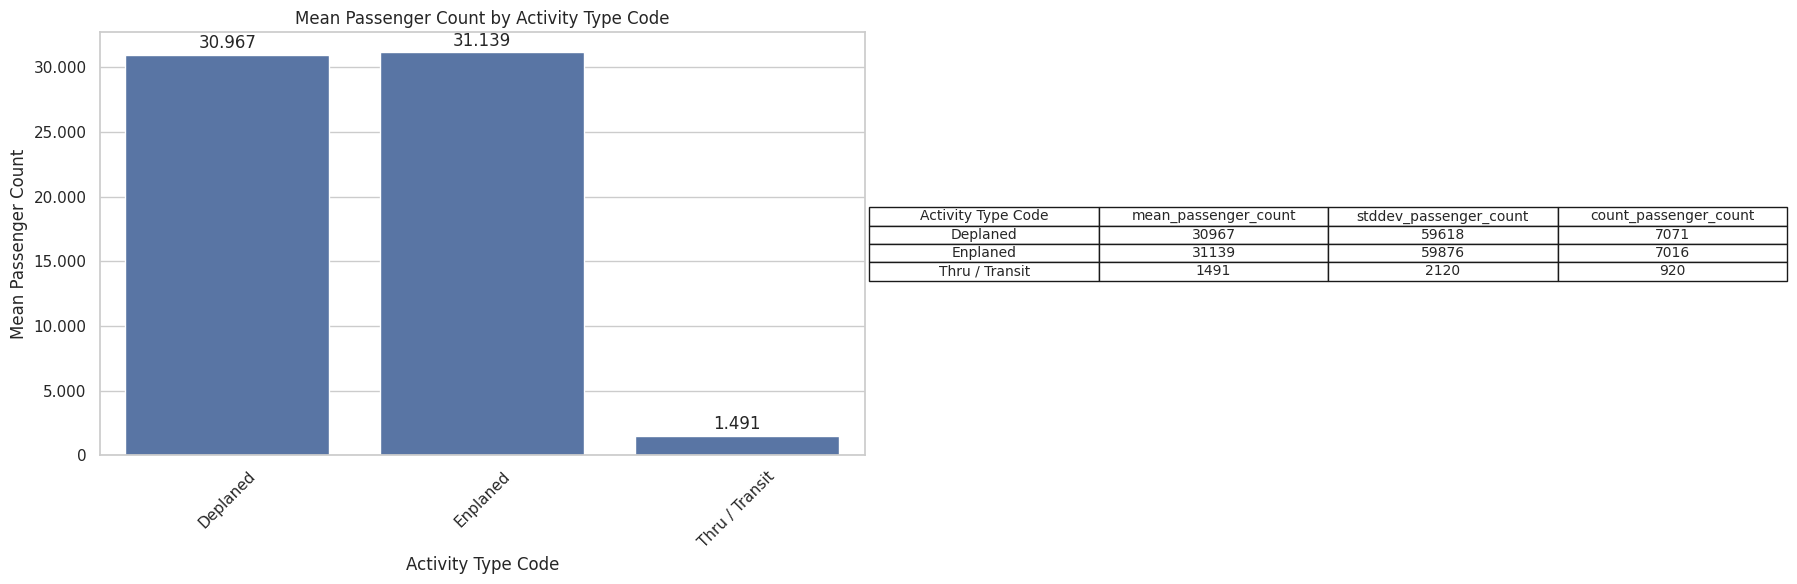

<ipython-input-13-92ce4f915c54>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


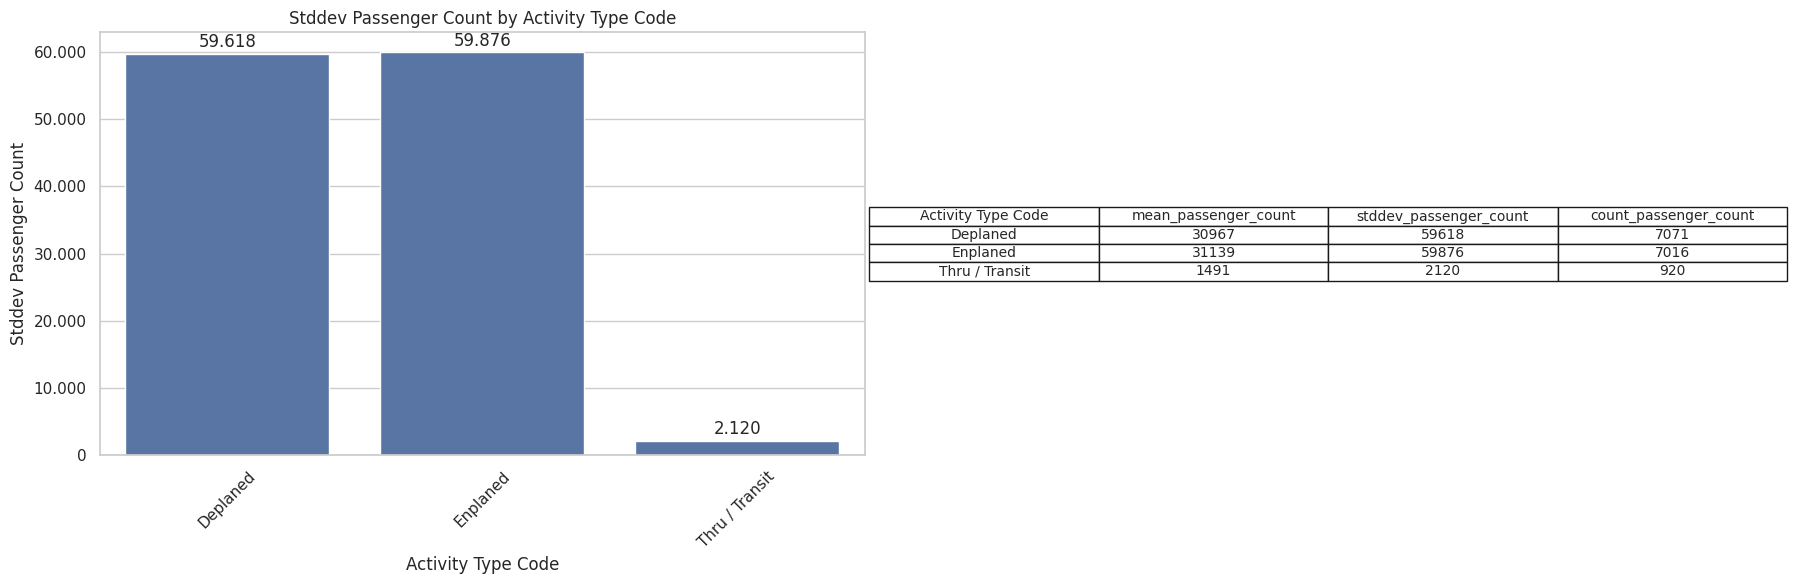

In [ ]:
# Relacionar Passenger Count con Activity Type Code
passenger_activity_type_stats = df.groupBy("Activity Type Code").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas sin decimales
passenger_activity_type_stats['mean_passenger_count'] = passenger_activity_type_stats['mean_passenger_count'].round(0).astype(int)
passenger_activity_type_stats['stddev_passenger_count'] = passenger_activity_type_stats['stddev_passenger_count'].fillna(0).round(0).astype(int)
passenger_activity_type_stats['count_passenger_count'] = passenger_activity_type_stats['count_passenger_count'].round(0).astype(int)

# Ordenar las estadísticas alfabéticamente por Activity Type Code
passenger_activity_type_stats = passenger_activity_type_stats.sort_values('Activity Type Code')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Visualizar la tabla y el gráfico lado a lado (mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_activity_type_stats, x='Activity Type Code', y='mean_passenger_count', ax=ax1)
ax1.set_title('Mean Passenger Count by Activity Type Code')
ax1.set_xlabel('Activity Type Code')
ax1.set_ylabel('Mean Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_activity_type_stats.iterrows():
    ax1.annotate(f"{row['mean_passenger_count']:,.0f}".replace(',', '.'), (row['Activity Type Code'], row['mean_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_activity_type_stats.values, colLabels=passenger_activity_type_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Visualizar la tabla y el gráfico lado a lado (stddev)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_activity_type_stats, x='Activity Type Code', y='stddev_passenger_count', ax=ax1)
ax1.set_title('Stddev Passenger Count by Activity Type Code')
ax1.set_xlabel('Activity Type Code')
ax1.set_ylabel('Stddev Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_activity_type_stats.iterrows():
    ax1.annotate(f"{row['stddev_passenger_count']:,.0f}".replace(',', '.'), (row['Activity Type Code'], row['stddev_passenger_count']), textcoords="offset points", xytext=(0,5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_activity_type_stats.values, colLabels=passenger_activity_type_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

<ipython-input-15-1d56fb82383d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


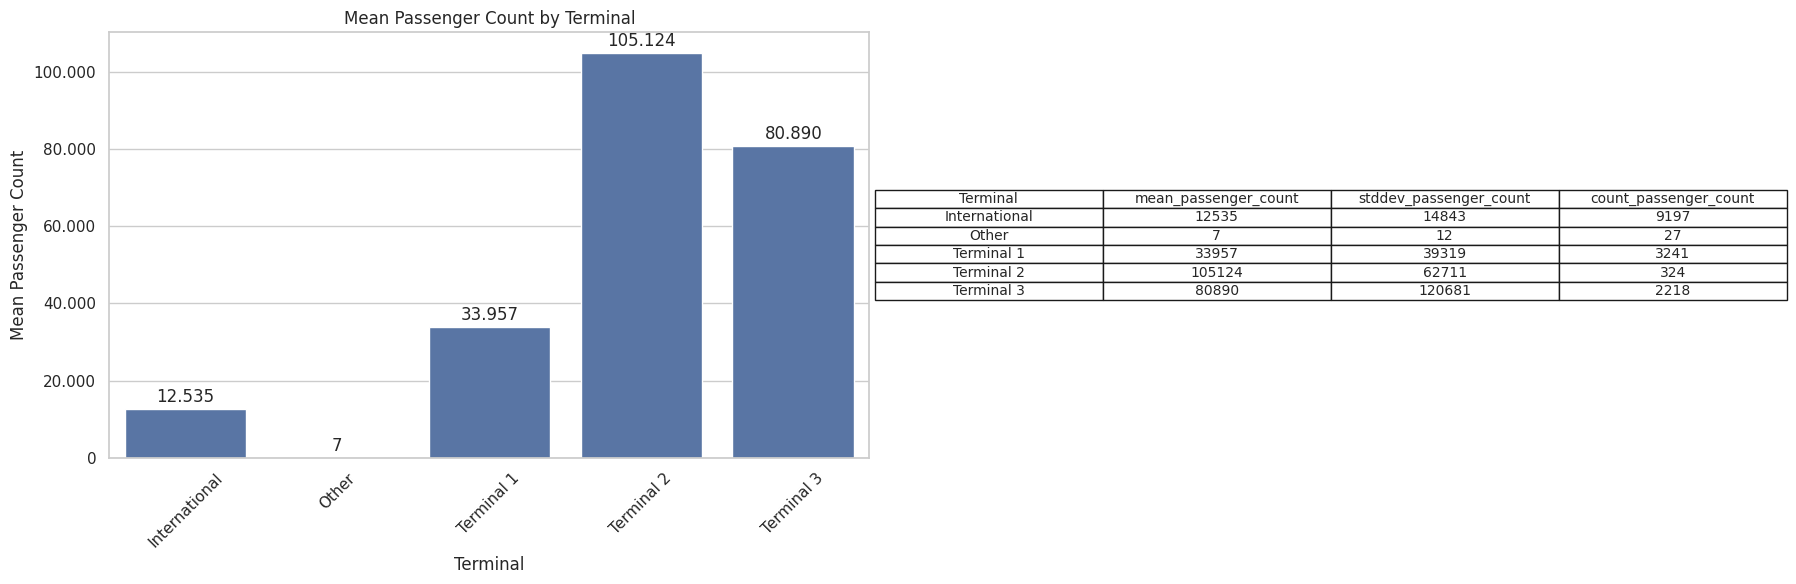

<ipython-input-15-1d56fb82383d>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


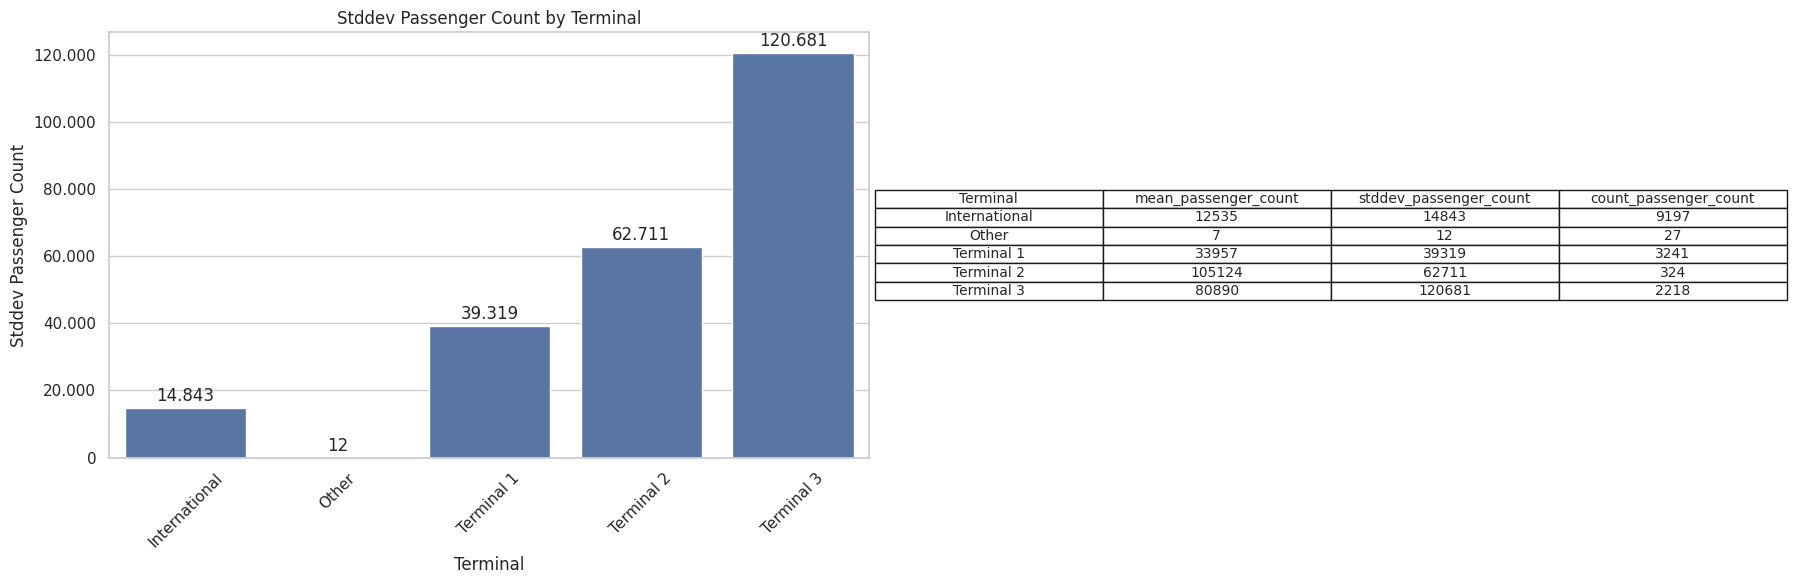

In [ ]:
# Relacionar Passenger Count con Terminal
passenger_terminal_stats = df.groupBy("Terminal").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas sin decimales
passenger_terminal_stats['mean_passenger_count'] = passenger_terminal_stats['mean_passenger_count'].round(0).astype(int)
passenger_terminal_stats['stddev_passenger_count'] = passenger_terminal_stats['stddev_passenger_count'].fillna(0).round(0).astype(int)
passenger_terminal_stats['count_passenger_count'] = passenger_terminal_stats['count_passenger_count'].round(0).astype(int)

# Ordenar las estadísticas alfabéticamente por Terminal
passenger_terminal_stats = passenger_terminal_stats.sort_values('Terminal')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Visualizar la tabla y el gráfico lado a lado (mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_terminal_stats, x='Terminal', y='mean_passenger_count', ax=ax1)
ax1.set_title('Mean Passenger Count by Terminal')
ax1.set_xlabel('Terminal')
ax1.set_ylabel('Mean Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_terminal_stats.iterrows():
    ax1.annotate(f"{row['mean_passenger_count']:,.0f}".replace(',', '.'), (row['Terminal'], row['mean_passenger_count']), textcoords="offset points", xytext=(0, 5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_terminal_stats.values, colLabels=passenger_terminal_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Visualizar la tabla y el gráfico lado a lado (stddev)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_terminal_stats, x='Terminal', y='stddev_passenger_count', ax=ax1)
ax1.set_title('Stddev Passenger Count by Terminal')
ax1.set_xlabel('Terminal')
ax1.set_ylabel('Stddev Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_terminal_stats.iterrows():
    ax1.annotate(f"{row['stddev_passenger_count']:,.0f}".replace(',', '.'), (row['Terminal'], row['stddev_passenger_count']), textcoords="offset points", xytext=(0, 5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_terminal_stats.values, colLabels=passenger_terminal_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

<ipython-input-17-f2cbfff9053f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)


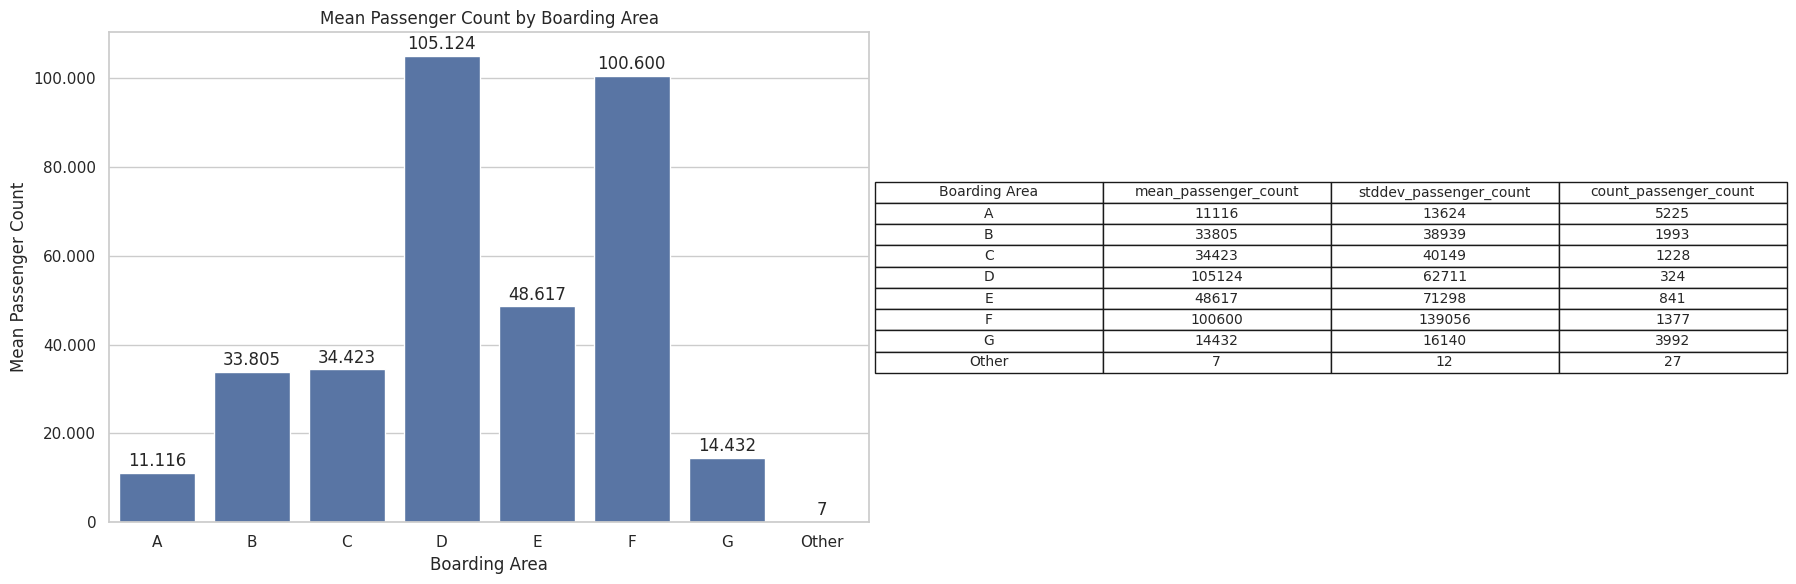

<ipython-input-17-f2cbfff9053f>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)


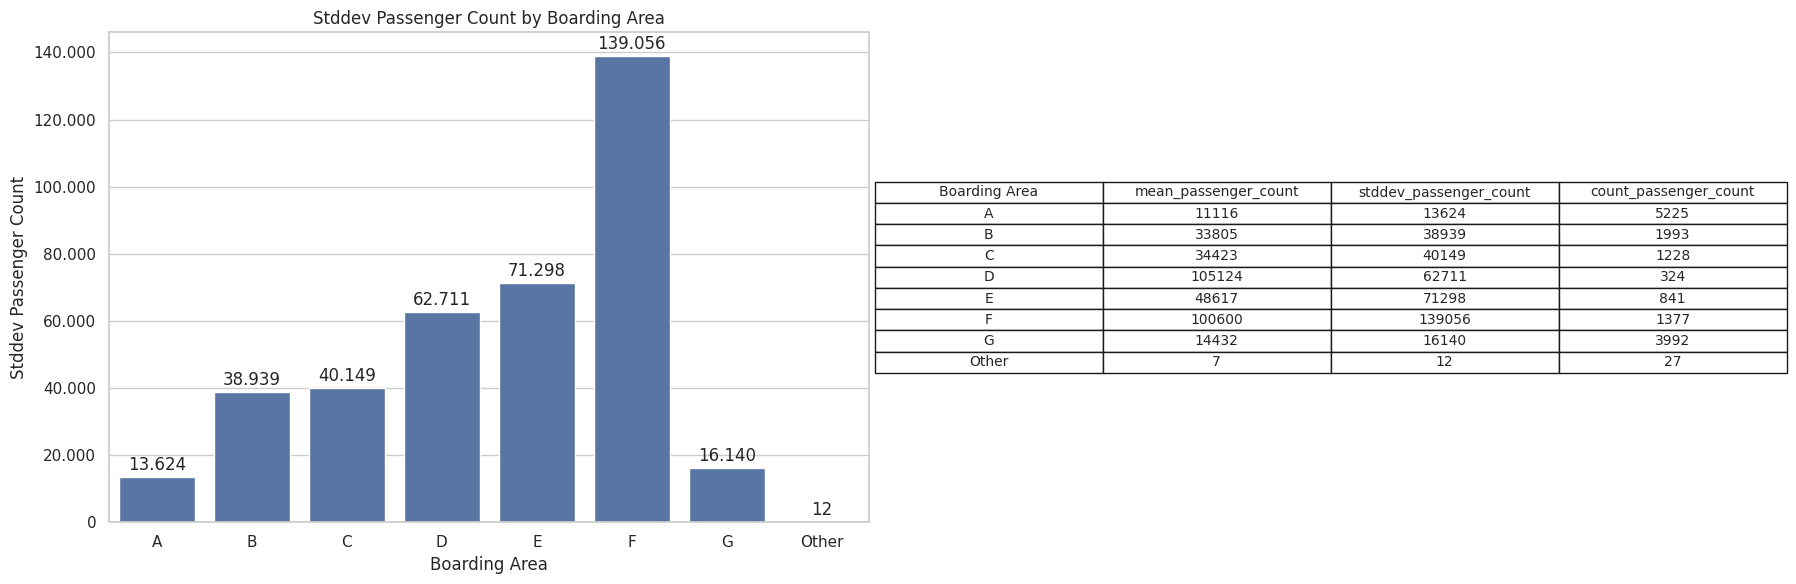

In [ ]:
# Relacionar Passenger Count con Boarding Area
passenger_boarding_area_stats = df.groupBy("Boarding Area").agg(
    mean("Passenger Count").alias("mean_passenger_count"),
    stddev("Passenger Count").alias("stddev_passenger_count"),
    count("Passenger Count").alias("count_passenger_count")
).toPandas()

# Redondear las estadísticas sin decimales
passenger_boarding_area_stats['mean_passenger_count'] = passenger_boarding_area_stats['mean_passenger_count'].round(0).astype(int)
passenger_boarding_area_stats['stddev_passenger_count'] = passenger_boarding_area_stats['stddev_passenger_count'].fillna(0).round(0).astype(int)
passenger_boarding_area_stats['count_passenger_count'] = passenger_boarding_area_stats['count_passenger_count'].round(0).astype(int)

# Ordenar las estadísticas alfabéticamente por Boarding Area
passenger_boarding_area_stats = passenger_boarding_area_stats.sort_values('Boarding Area')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Visualizar la tabla y el gráfico lado a lado (mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_boarding_area_stats, x='Boarding Area', y='mean_passenger_count', ax=ax1)
ax1.set_title('Mean Passenger Count by Boarding Area')
ax1.set_xlabel('Boarding Area')
ax1.set_ylabel('Mean Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_boarding_area_stats.iterrows():
    ax1.annotate(f"{row['mean_passenger_count']:,.0f}".replace(',', '.'), (row['Boarding Area'], row['mean_passenger_count']), textcoords="offset points", xytext=(0, 5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_boarding_area_stats.values, colLabels=passenger_boarding_area_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

# Visualizar la tabla y el gráfico lado a lado (stddev)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=passenger_boarding_area_stats, x='Boarding Area', y='stddev_passenger_count', ax=ax1)
ax1.set_title('Stddev Passenger Count by Boarding Area')
ax1.set_xlabel('Boarding Area')
ax1.set_ylabel('Stddev Passenger Count')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
for i, row in passenger_boarding_area_stats.iterrows():
    ax1.annotate(f"{row['stddev_passenger_count']:,.0f}".replace(',', '.'), (row['Boarding Area'], row['stddev_passenger_count']), textcoords="offset points", xytext=(0, 5), ha='center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=passenger_boarding_area_stats.values, colLabels=passenger_boarding_area_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

In [ ]:
# Columnas categóricas que necesitamos convertir
categorical_columns = ['Operating Airline', 'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal', 'Boarding Area', 'Month']

# Crear un índice para cada columna categórica
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_Index")
    df = indexer.fit(df).transform(df)

# Seleccionar solo las columnas necesarias para la matriz de correlación
selected_columns = ['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year'] + [col + "_Index" for col in categorical_columns]
df_selected = df.select(selected_columns)

# Convertir a DataFrame de Pandas para la matriz de correlación
pandas_df = df_selected.toPandas()


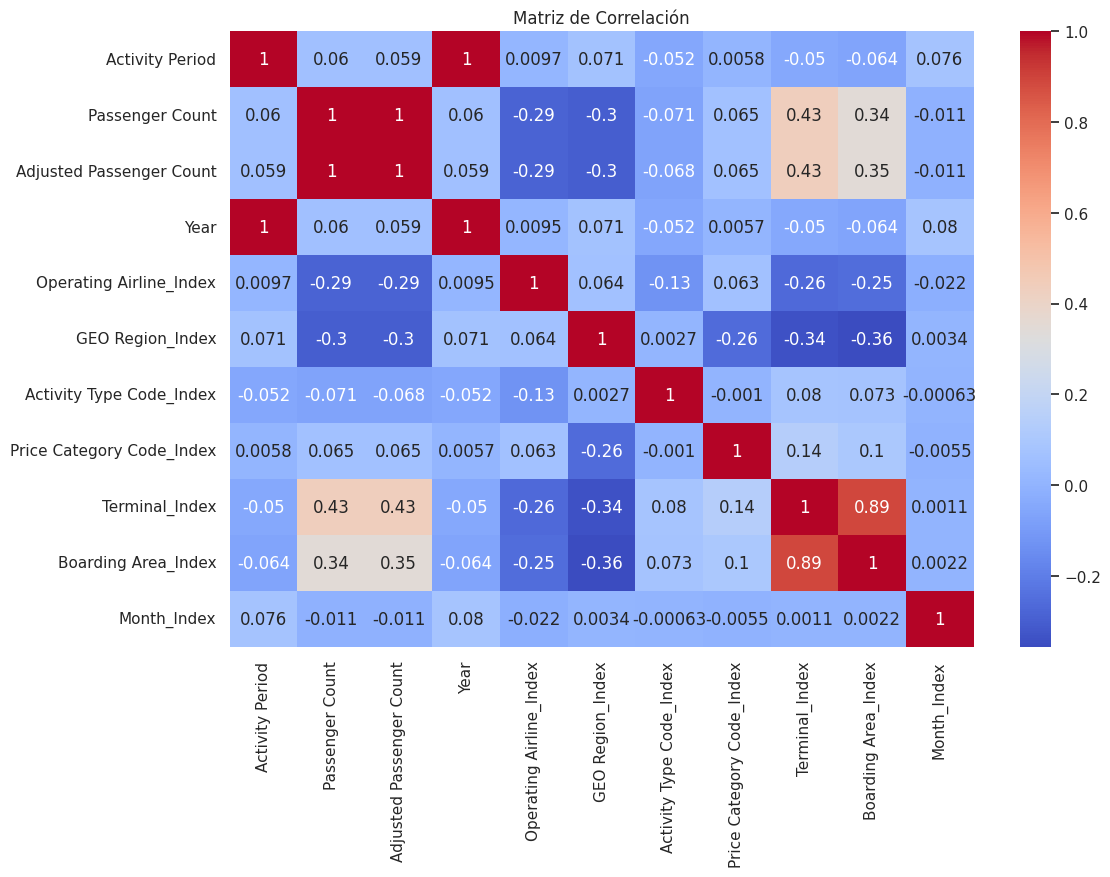

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = pandas_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

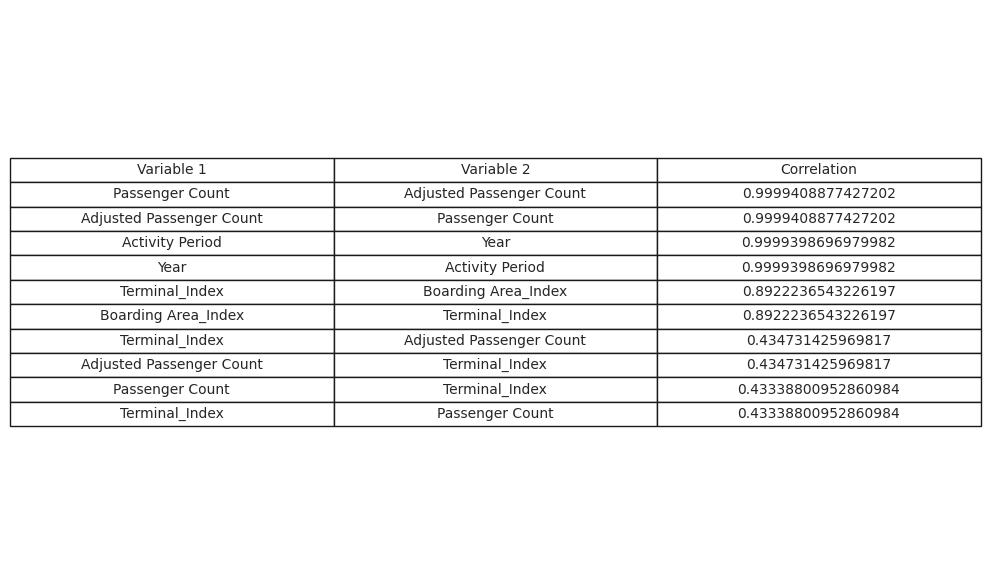

In [ ]:
# Seleccionar las 10 correlaciones más altas (excluyendo 1.0 que es la correlación de una variable consigo misma)
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Filtrar las correlaciones más altas excluyendo los 1.0
high_corr_pairs = sorted_pairs[(sorted_pairs < 1) & (sorted_pairs > -1)].head(10)

# Convertir las correlaciones más altas en un DataFrame para visualización
high_corr_pairs_df = high_corr_pairs.reset_index()
high_corr_pairs_df.columns = ['Variable 1', 'Variable 2', 'Correlation']
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=high_corr_pairs_df.values, colLabels=high_corr_pairs_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

In [ ]:
# Ensamblar las características en una sola columna de características
assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
df_features = assembler.transform(df)

# Mostrar las primeras filas del DataFrame con características ensambladas
df_features.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[200507.0,27271.0...|
|[200507.0,29131.0...|
|[200507.0,5415.0,...|
|[200507.0,35156.0...|
|[200507.0,34090.0...|
+--------------------+
only showing top 5 rows



In [ ]:
# Configurar el modelo K-Means
kmeans = KMeans().setK(5).setSeed(1)  # K=5 para agrupar en 5 clusters

# Entrenar el modelo
model = kmeans.fit(df_features)

# Hacer predicciones
predictions = model.transform(df_features)

# Mostrar las predicciones
predictions.select('features', 'prediction').show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[200507.0,27271.0...|         0|
|[200507.0,29131.0...|         0|
|[200507.0,5415.0,...|         0|
|[200507.0,35156.0...|         3|
|[200507.0,34090.0...|         3|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# Evaluar el modelo
wssse = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 4360554686653.2505


       Passenger Count  Adjusted Passenger Count  prediction
0                27271                     27271           0
1                29131                     29131           0
2                 5415                     10830           0
3                35156                     35156           3
4                34090                     34090           3
...                ...                       ...         ...
15002           194636                    194636           4
15003             4189                      4189           0
15004             4693                      4693           0
15005            12313                     12313           0
15006            10898                     10898           0

[15007 rows x 3 columns]


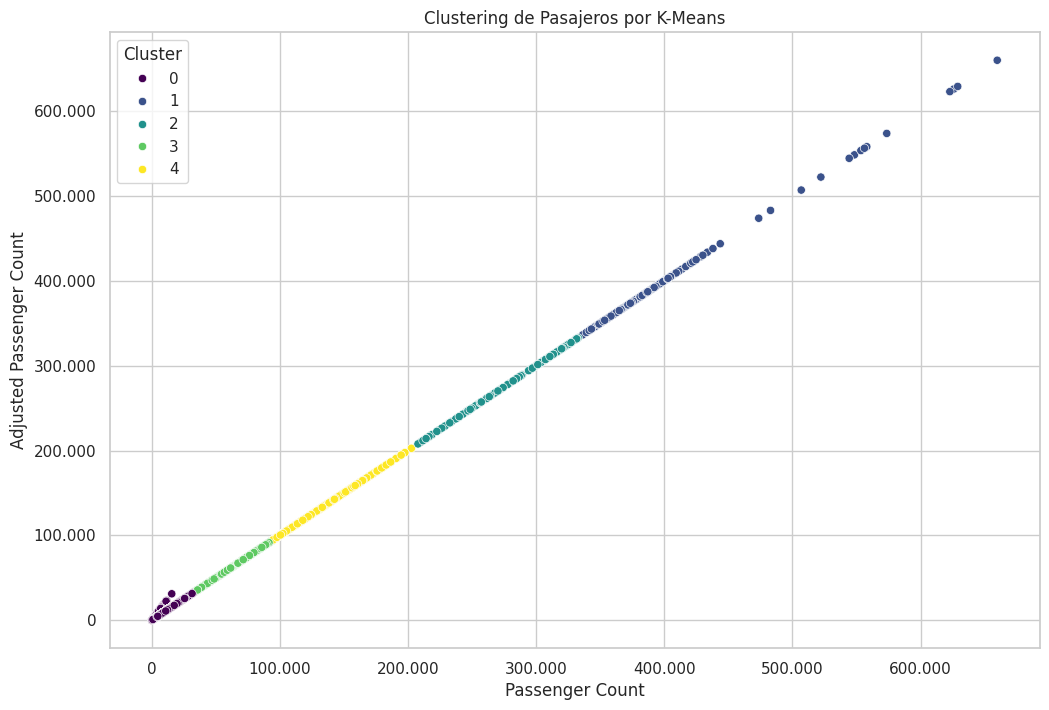

In [ ]:
# Convertir a DataFrame de Pandas para la visualización
predictions_pd = predictions.select('Passenger Count', 'Adjusted Passenger Count', 'prediction').toPandas()

print(predictions_pd)

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
sns.scatterplot(data=predictions_pd, x='Passenger Count', y='Adjusted Passenger Count', hue='prediction', palette='viridis')
plt.title('Clustering de Pasajeros por K-Means')
plt.xlabel('Passenger Count')
plt.ylabel('Adjusted Passenger Count')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y).replace(',', '.')))
plt.legend(title='Cluster')
plt.show()